In [163]:
import numpy as np
import pandas as pd
import time

from functools import partial
from scipy.stats import randint, uniform, beta
from sim_lib import simulation

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"] = 100

pd.options.mode.chained_assignment = None

## Epsilon-greedy policy (homework baseline)

### Epsilon-greedy policy function definition

In [10]:
def eps_greedy(history: pd.DataFrame, eps: float) -> int:
    if uniform.rvs() < eps:
        n = history.shape[0]
        return history.index[randint.rvs(0, n)]

    ctr = history['clicks'] / (history['impressions'] + 10)
    n = np.argmax(ctr)
    return history.index[n]

policy = partial(eps_greedy, eps=0.08)

### Epsilon-greedy policy simulation test

In [11]:
# seed for homework
np.random.seed(seed=384758917)

start = time.time()
output = simulation(policy, n=200000)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


311.72900199890137

### Homeword baseline regret

In [12]:
# baseline regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(2792.237649427154, 0.01396118824713577, 174)

Это был epsilon-greedy бандит, который является бейзлайном по второй домашней работе. Теперь посмотрим на бандита, делающего абсолютно случайное предсказание.

## Absolutely random prediction

In [83]:
def random_policy(history: pd.DataFrame) -> int:
    n = history.shape[0]
    return history.index[randint.rvs(0, n)]

policy = partial(random_policy)

In [85]:
np.random.seed(seed=384758917)
output = simulation(policy, n=200000)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


In [86]:
# random-policy regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(15835.566358110453, 0.07917783179055227, 175)

Довольно ужасно, в 5 раз хуже регрет чем в epsilon-greedy полиси. Теперь реализуем UCB бандита, в соответствии с формулой с лекции.

## Upper-confidence bound policy

### Upper-confidence bound policy function definition

На лекции было:
$$n = \arg\max_i\left(\hat{\theta}_{i, t} + \sqrt{\dfrac{2\log \sum_j n_j}{n_i}}\right)$$

Поскольку в функции `simulation` каждая новая ручка изначально с нулевым счетчиком дергания ручек (impressions), то для избежания проблем нулевого логарифма и нулевого знаменателя, добавим к каждой ручке + 10 в знаменателе и + 10 к сумме всех дерганий ручек, тогда формула будет следующей:
$$n = \arg\max_i\left(\hat{\theta}_{i, t} + \sqrt{\dfrac{2\log\left(\sum_j n_j + 10\right)}{n_i + 10}}\right)$$

In [87]:
def upper_confidence_bound(history: pd.DataFrame) -> int:
    ctr = history['clicks'] / (history['impressions'] + 10) 
    addition = np.sqrt(2 * np.log2(history['impressions'].sum() + 10) / (history['impressions'] + 10))
    upper_bound = ctr + addition
    n = np.argmax(upper_bound)
    return history.index[n]

### Upper-confidence bound policy simulation test

In [88]:
policy = partial(upper_confidence_bound)
np.random.seed(seed=384758917)
output = simulation(policy, n=200000)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


### Upper-confidence bound simulation results

In [89]:
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(9761.857770213202, 0.048809288851066016, 185)

Довольно грустный результат: регрет хуже, чем у эпсилон гриди алгоритма и лишь в полтора раза лучше чем регрет по случайному выбору. Возможно так произошло из за слишком широкого, или слишком узкого доверительного интервала, то есть либо крайность с exploration, либо крайность с exploitation. Хочется каким-либо образом попробовать изменить формулу, что и будет сделано далее в эврстической модификации UCB.

## Upper-confidence bound heuristic modification

Обычный UCB работает довольно плохо, даже хуже бейзлайна с epsilon-greedy бандитом, давайте попробуем регулировать размер доверительного интервала, добавив два гиперпараметра $\alpha$ и $\beta$, отвечающие за exploration exploitation trade-off. Тогда формула примет вид: 
$$n = \arg\max_i\left(\hat{\theta}_{i, t} + \alpha \cdot \sqrt{\dfrac{\beta\log\left(\sum_j n_j + 10\right)}{n_i + 10}}\right)$$

In [127]:
def upper_confidence_bound_custom(history: pd.DataFrame, alpha: float, beta: float) -> int:
    ctr = history['clicks'] / (history['impressions'] + 10) 
    addition = np.sqrt(beta * np.log2(history['impressions'].sum() + 10) / (history['impressions'] + 10))
    upper_bound = ctr + alpha * addition
    n = np.argmax(upper_bound)
    return history.index[n]

Ожидается, что для каждой задачи гиперпараметры $\alpha$ и $\beta$ будут разный, поэтому подберем его для конкретно нашей задачи.

In [134]:
alphas = [0.1, 0.4, 0.7, 1]
betas = [0.1, 0.5, 1, 1.5, 2]
regret = {alpha: {beta: 0 for beta in betas} for alpha in alphas}
avg_regret_per_round = {alpha: {beta: 0 for beta in betas} for alpha in alphas}
for a in alphas:
    for b in betas:
        policy = partial(upper_confidence_bound_custom, alpha=a, beta=b)
        np.random.seed(seed=384758917)
        output = simulation(policy, n=40000)
        regret[a][b] = output['regret']
        avg_regret_per_round[a][b] = output['regret']/output['rounds']

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30

In [177]:
# суммарный регрет для каждого набора протестированных параметров
tmp = pd.DataFrame(regret)
tmp.index = [f"beta_{beta}" for beta in tmp.index.tolist()]
tmp.columns = [f"alpha_{alpha}" for alpha in tmp.columns.tolist()]
tmp

,alpha_0.1,alpha_0.4,alpha_0.7,alpha_1.0
beta_0.1,2723.876480,603.261589,149.211966,319.691997
beta_0.5,1117.981962,227.119617,649.059395,1126.548385
beta_1.0,866.753187,494.519671,1097.300377,1691.365962
beta_1.5,413.517255,633.199163,1433.693791,2095.852988
beta_2.0,52.891261,772.140150,1729.038260,2399.399555


In [179]:
# среднераундовый регрет для каждого набора протестированных параметров
tmp = pd.DataFrame(avg_regret_per_round)
tmp.index = [f"beta_{beta}" for beta in tmp.index.tolist()]
tmp.columns = [f"alpha_{alpha}" for alpha in tmp.columns.tolist()]
tmp

,alpha_0.1,alpha_0.4,alpha_0.7,alpha_1.0
beta_0.1,0.068097,0.015082,0.003730,0.007992
beta_0.5,0.027950,0.005678,0.016226,0.028164
beta_1.0,0.021669,0.012363,0.027433,0.042284
beta_1.5,0.010338,0.015830,0.035842,0.052396
beta_2.0,0.001322,0.019304,0.043226,0.059985


Какой-то монотонности регрета по гиперпараметрам не наблюдается, однако, лучший регрет достигается при $\alpha = 0.1, \beta=2$. Проведем симуляцию для такого набора гиперпараметров.

In [142]:
policy = partial(upper_confidence_bound_custom, alpha=0.1, beta=2.0)
np.random.seed(seed=384758917)
output = simulation(policy, n=200000)
output['regret'], output['regret']/output['rounds'],  output['total_banners']

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


(789.2363432275638, 0.003946181716137819, 185)

In [144]:
9761/789

12.371356147021546

Суммарный регрет стал ниже в целых 12 раз и стал ниже бейзлайна! Удивительный результат, который получился, по сути изменив, всего один множитель в формуле $\alpha = 1 \Rightarrow \alpha = 0.1$ (один множитель потому что $\beta=2$ изначально).

Интересно сравнить результаты этой кастомной UCB полиси с томсон семплингом, поэтому теперь реализуем бандита с thompson sampling полиси.

## Thompson sampling policy

### Thompson sampling policy function definition

In [164]:
def thompson_sampling(history: pd.DataFrame) -> int:
    successes = history['clicks']
    trials = history['impressions']
    probabilities = [beta.rvs(a + 1, b + 1) for (a, b) in np.array([successes, trials]).T]
    n = np.argmax(probabilities)
    return history.index[n]

### Upper-confidence bound policy simulation test

In [17]:
policy = partial(thompson_sampling)
np.random.seed(seed=384758917)
output = simulation(policy, n=200000)

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


### Upper-confidence bound simulation results

In [18]:
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(1644.1417058505945, 0.008220708529252971, 205)

Регрет суммарный томпсон семплингом ниже бейзлайна, но он почти в два раза больше, чем у кастомной UCB полиси. 

Теперь, после реализации различных полиси, хочется посмотреть, как ведет себя суммарный регрет на дистанции для каждой из полиси. 

Для этого функция `simulation` была немного модифицирована: гиперпараметры не были тронуты, был лишь добавлен словарик, в который на каждой итерации симуляции складываются текущие результаты, чтобы можно было рисовать "непрерывные" графики.

## Overall comparrison of all policies

In [173]:
results_simulation = {
    'epsilon_greedy_0.05': None,
    'epsilon_greedy_0.08': None,
    'epsilon_greedy_0.11': None,
    'upper_confidence_bound': None,
    'upper_confidence_bound_custom': None,
    'thompson_sampling': None
}

In [174]:
np.random.seed(seed=384758917)
n_iterations = 200000
for epsilon in [0.05, 0.08, 0.11]:
    policy = partial(eps_greedy, eps=epsilon)
    result = simulation(policy, n=n_iterations)['results']
    results_simulation[f'epsilon_greedy_{epsilon}'] = result
policy = partial(upper_confidence_bound)
results_simulation['upper_confidence_bound'] = simulation(policy, n=n_iterations)['results']
policy = partial(upper_confidence_bound_custom, alpha=0.1, beta=2.0)
results_simulation['upper_confidence_bound_custom'] = simulation(policy, n=n_iterations)['results']
policy = partial(thompson_sampling)
results_simulation['thompson_sampling'] = simulation(policy, n=n_iterations)['results']

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impr

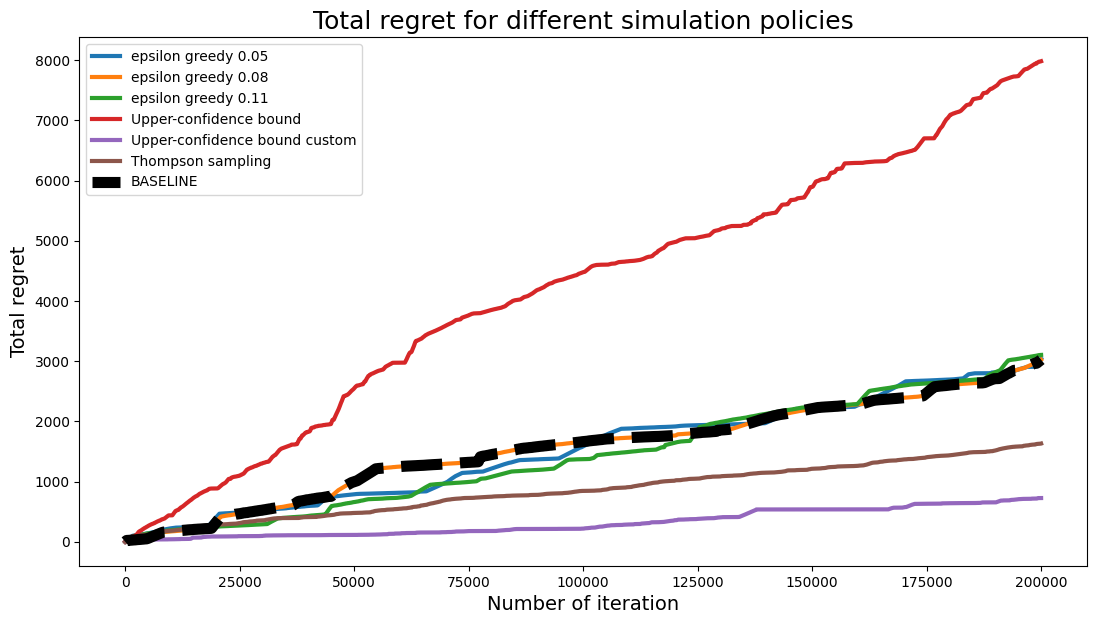

In [176]:
plt.figure(figsize=(13, 7))
plt.plot(results_simulation['epsilon_greedy_0.05']['n'], 
         results_simulation['epsilon_greedy_0.05']['regret'], 
         label='epsilon greedy 0.05',
         linewidth=3)
plt.plot(results_simulation['epsilon_greedy_0.08']['n'], 
         results_simulation['epsilon_greedy_0.08']['regret'], 
         label='epsilon greedy 0.08',
         linewidth=3)
plt.plot(results_simulation['epsilon_greedy_0.11']['n'], 
         results_simulation['epsilon_greedy_0.11']['regret'], 
         label='epsilon greedy 0.11',
         linewidth=3)
plt.plot(results_simulation['upper_confidence_bound']['n'], 
         results_simulation['upper_confidence_bound']['regret'], 
         label='Upper-confidence bound',
         linewidth=3)
plt.plot(results_simulation['upper_confidence_bound_custom']['n'], 
         results_simulation['upper_confidence_bound_custom']['regret'], 
         label='Upper-confidence bound custom',
         linewidth=3)
plt.plot(results_simulation['thompson_sampling']['n'], 
         results_simulation['thompson_sampling']['regret'], 
         label='Thompson sampling',
         linewidth=3)
plt.plot(results_simulation['epsilon_greedy_0.08']['n'], 
         results_simulation['epsilon_greedy_0.08']['regret'],  
         label='BASELINE', color='black', 
         # marker='o',
         linestyle='dashed', 
         linewidth=8, 
         # markersize=8
        )

plt.title('Total regret for different simulation policies', size=18)
plt.xlabel('Number of iteration', size=14)
plt.ylabel('Total regret', size=14)
plt.legend()
plt.show();

Интересные результаты из графика суммарного регрета для каждой полиси:
- Видно, что стандартный UCB ведет себя крайнее плохо, значительно хуже стандартных эпсилон гриди полиси, прям в разы хуже
- Начиная с, приблизительно, 150000 итерации, графически три эпсилон гриди полиси асимптотически сходятся друг к другу, это не совсем интуитивно очевидно
- Лучшей полиси по минимальному суммарному регрету является кастомная UCB, далее идет thompson sampling

## Conclusion

В ходе выполнения домашнего задания были реализованы следующие полиси:
- Абсолютно случайная полиси - случайный выбор ручки, которая будет дернута
- Upper-confidence bound
- Upper-confidence bound custom - с кастомными гиперпараметрами
- Thompson sampling

Бейзлайн размером в 2792 суммарный регрет был побит: 
- лучший результат показала кастомная upper-confidence bound полиси с гиперпараметрами $\alpha = 0.1, \beta=2$ - суммарный регрет для нее оказался равен 789, что почти в 4 раза меньше бейзлана
- следующая за кастомной upper-confidence bound полиси оказалась полиси thompson sampling - для нее суммарный регрет оказался равен 1644, что в ~2 раза меньше бейзлайна.

_Комментарий_: в самом конце домашнего задания понял, что проделал лишнюю работу, указав в кастомной два гиперпараметра $\alpha, \beta$ в формуле:
$$n = \arg\max_i\left(\hat{\theta}_{i, t} + \alpha \cdot \sqrt{\dfrac{\beta\log\left(\sum_j n_j + 10\right)}{n_i + 10}}\right)$$

Поскольку: $\alpha \sqrt{\beta \cdot \dots} = \alpha \cdot \sqrt{\beta} \sqrt{\dots} = \gamma \sqrt{\dots}$

Получается, что разумнее было бы указать один гиперпараметр, либо внутри корня, либо снаружи, потому что корень - монотонная фукнция, все было бы ок. И получается необходимо было подбирать лишь один параметр, а не два. Но уже сделал как сделал, надеюсь это не будет посчитано за ошибку.